In [63]:
import os
import random
import cv2
import numpy as np

from regions.selectivesearch_answer import selective_search
# from regions.selectivesearch import selective_search

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from chainercv.links import FeaturePredictor
from chainercv.links import VGG16

%matplotlib inline 

with open('./clsid_to_name.txt', 'r') as f:
    classes = list(map(lambda l: l.strip(), f.readlines()))

In [64]:
# DIRECTORY
DIR = '/data/unagi0/ilsvrc2017/ILSVRC/'

# GPU (-1 if performing on CPU)
GPU = -1

# IMAGE SELECTION PARAMETERS
RANDOM_SEED = 200
NUMBER_OF_IMAGES = 1

# SELECTIVE-SEARCH PARAMETERS
SCALE = 250
SIGMA = 0.9
MIN_SIZE = 50
MIN_REGION = 2000
MAX_RATIO = 1.2


In [65]:
# Get image filenames from val.txt image set
with open(os.path.join(DIR, 'ImageSets/DET/val.txt')) as f:
    dataset = list(map(lambda f: f.strip().split()[0], f.readlines()))

# Sample random images from dataset
random.seed(RANDOM_SEED)
sample = random.sample(range(len(dataset)), NUMBER_OF_IMAGES)
image_paths = [os.path.join(DIR, 'Data/DET/val', dataset[i] + '.JPEG') for i in sample]

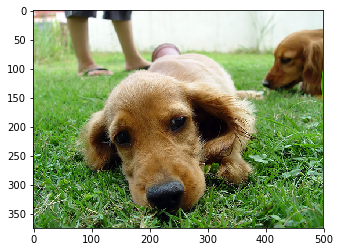

In [66]:
# Load and Display images
imgs = list()
for img_file in image_paths:
    img = mpimg.imread(img_file)
    imgs.append({"original": img})
    plt.figure()
    plt.imshow(img)

38
CPU times: user 2.83 s, sys: 39.4 ms, total: 2.87 s
Wall time: 2.89 s


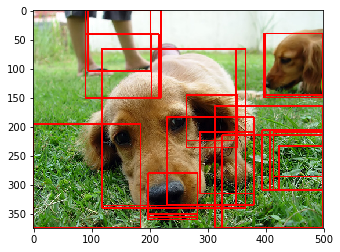

In [70]:
%%time
# Perform selective search on each image

for img in imgs:
    img_lbl, regions = selective_search(img["original"], scale=SCALE, sigma=SIGMA, min_size=MIN_SIZE)
    img["cropped_regions"] = []
    img_copy = img["original"].copy() # image copy for drawing regions and displaying
    
    for region in regions:
        x, y, w, h = region['rect']
        if (region['size'] < MIN_REGION) or (w / h > MAX_RATIO) or (h / w > MAX_RATIO):
            continue
        
        # axis order and data type changed in preparation for input into CNN model
        img["cropped_regions"].append(np.moveaxis(img["original"][y:y+h,x:x+w,:],2,0).astype(np.float32))
        
        # for displaying regions (copies are made so as to not leave red borders in original image)
        cv2.rectangle(img_copy, (x, y), (x+w, y+h), 0xFF3333, thickness=2)
    
    plt.figure()
    plt.imshow(img_copy)
    print(len(img["cropped_regions"]))   

In [71]:
# Initialize VGG16 classifier model
extractor = VGG16(1000, 'imagenet')
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')

In [72]:
if GPU >= 0:
    chainer.cuda.get_device(GPU).use()
    model.to_gpu()
prob = model.predict(cropped_regions[0])

In [73]:
for i, p in enumerate(prob):
    if np.max(p) > 0.3:
        print("%d: class: %s\t\tprob: %f" % (i, classes[np.argmax(p)], np.max(p) ))

1: class: 219: 'cocker spaniel, English cocker spaniel, cocker',		prob: 0.595673
2: class: 154: 'Pekinese, Pekingese, Peke',		prob: 0.392814
12: class: 219: 'cocker spaniel, English cocker spaniel, cocker',		prob: 0.788161
14: class: 187: 'Yorkshire terrier',		prob: 0.427025
15: class: 187: 'Yorkshire terrier',		prob: 0.427025
16: class: 187: 'Yorkshire terrier',		prob: 0.427025
17: class: 156: 'Blenheim spaniel',		prob: 0.525206
18: class: 219: 'cocker spaniel, English cocker spaniel, cocker',		prob: 0.595673
19: class: 187: 'Yorkshire terrier',		prob: 0.427025
20: class: 156: 'Blenheim spaniel',		prob: 0.525207
21: class: 387: 'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens',		prob: 0.350391
22: class: 220: 'Sussex spaniel',		prob: 0.322551
26: class: 219: 'cocker spaniel, English cocker spaniel, cocker',		prob: 0.595673
29: class: 220: 'Sussex spaniel',		prob: 0.322551
30: class: 220: 'Sussex spaniel',		prob: 0.322551
32: class: 213: 'Irish setter, red setter',	

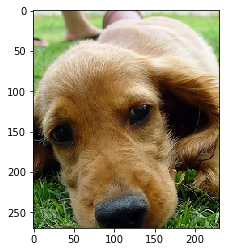

In [74]:
plt.imshow(np.moveaxis(cropped_regions[0][26],0,2).astype(np.uint8))